<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 4. Regresi√≥n lineal: simple y m√∫ltiple </span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iv√°n A. Toledano Ju√°rez </span>  </center>

# Regresi√≥n lineal simple del dataset Advertising

En este notebook exploraremos los fundamentos de la **regresi√≥n lineal**, utilizando el cl√°sico conjunto de datos `Advertising` del libro *An Introduction to Statistical Learning*. El contexto de este dataset puede revisarse en el [repositorio](https://github.com/IvTole/MachineLearning_InferenciaBayesiana_CUGDL/tree/main/data/advertising) del curso. Este dataset contiene informaci√≥n sobre el gasto en publicidad en distintos medios (TV, radio, peri√≥dico) y las ventas de un producto. A trav√©s de este ejemplo pr√°ctico, construiremos modelos de **regresi√≥n lineal simple y m√∫ltiple**, y aprenderemos a interpretar sus coeficientes, evaluar su desempe√±o y diagnosticar sus supuestos.

Adem√°s de utilizar librer√≠as como `scikit-learn` para ajustar modelos, realizaremos tambi√©n el ajuste **manualmente paso a paso**, calculando los coeficientes, los residuos, el **coeficiente de determinaci√≥n $R^2$**, y el **error est√°ndar de los residuos (RSE)**. Esto nos permitir√° entender m√°s a fondo los mecanismos internos del modelo y desarrollar una intuici√≥n s√≥lida sobre su funcionamiento. Este enfoque pr√°ctico y comparativo servir√° como base para modelar relaciones lineales en problemas reales de ciencia de datos.


In [1]:
# Importaci√≥n de librer√≠as

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
import os

# para combinaciones
from itertools import combinations

#statsmodels
import statsmodels.formula.api as smf

#scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## Importaci√≥n de datos

In [2]:
# Carga de datos

mainpath = "../data" 
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())  # se checa que est√© cargado bien
print("Dimensiones de los datos: ", df_advertising.shape)

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

Dimensiones de los datos:  (200, 4)


In [3]:
# informaci√≥n del dataframe
df_advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
df_advertising.isna().any() ## para checar que no haya valores nulos

TV           False
Radio        False
Newspaper    False
Sales        False
dtype: bool

Observamos que no tenemos valores nulos. Este dataset es para practicar y los datos ya vienen limpios.√á

In [5]:
# Estad√≠sticos b√°sicos
df_advertising.describe()

TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   14.022500
std     85.854236   14.846809   21.778621    5.217457
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   10.375000
50%    149.750000   22.900000   25.750000   12.900000
75%    218.825000   36.525000   45.100000   17.400000
max    296.400000   49.600000  114.000000   27.000000

### Valores at√≠picos

Si bien estos datos ya se encuentran limpios, no est√° de m√°s explorar si existen **valores at√≠picos** de las variables predictoras. Estos valores extremos pueden influir de manera significativa en los coeficientes de ajuste del modelo y afectar su interpretaci√≥n. En este caso vamos a detectarlos mediante diagramas de caja y bigote (boxplots), pero uno tambi√©n podr√≠a intuirlos haciendo un an√°lisis sobre los residuos una vez ajustado el modelo.

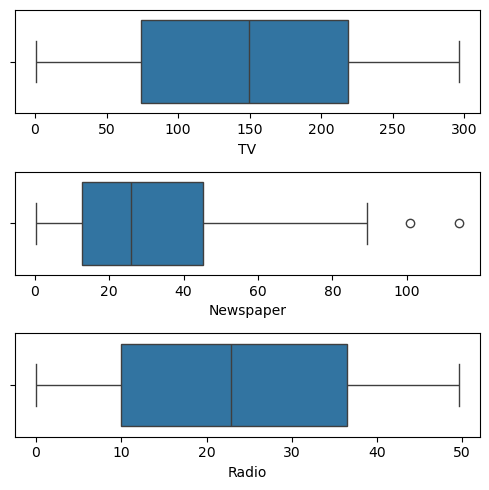

In [6]:
fig, axs = plt.subplots(3, figsize = (5,5))
plt1 = sns.boxplot(x = df_advertising['TV'], ax = axs[0])
plt2 = sns.boxplot(x = df_advertising['Newspaper'], ax = axs[1])
plt3 = sns.boxplot(x = df_advertising['Radio'], ax = axs[2])
plt.tight_layout()
plt.show()

Podemos observar con estos gr√°ficos que hay algunos valores at√≠picos en el caso de los datos de la variable `Newspaper`, la inversi√≥n que se hace en campa√±as de per√≠odico. Como no son muchos, los ignoramos por el momento. A continuaci√≥n, podemos hacer diagramas de dispersi√≥n, para ver la relaci√≥n entre las variables predictoras y la variable objetivo `Sales`.

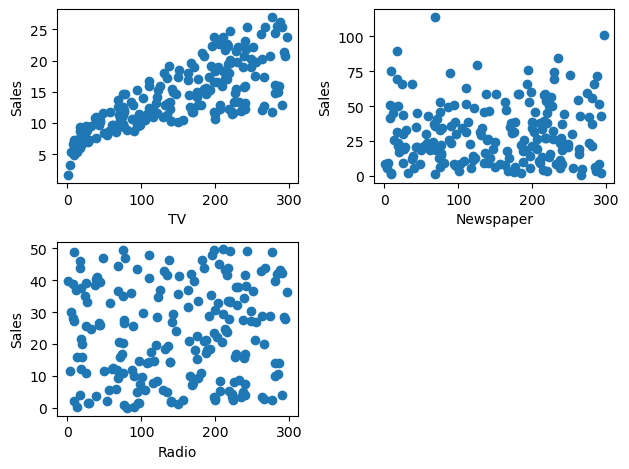

In [7]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.scatter(x=df_advertising['TV'],
            y=df_advertising['Sales'])
ax1.set_xlabel('TV')
ax1.set_ylabel('Sales')

ax2 = fig.add_subplot(222)
ax2.scatter(x=df_advertising['TV'],
            y=df_advertising['Newspaper'])
ax2.set_xlabel('Newspaper')
ax2.set_ylabel('Sales')

ax3 = fig.add_subplot(223)
ax3.scatter(x=df_advertising['TV'],
            y=df_advertising['Radio'])
ax3.set_xlabel('Radio')
ax3.set_ylabel('Sales')

fig.tight_layout() # para agregar una separaci√≥n entre subplots

plt.show()

Visualmente, podemos observar que hay una gran correlaci√≥n entre la variable predictora `TV` y la variable objetivo `Sales`. En este punto, es importante cuantificar este comportamiento con alg√∫n coeficiente de correlaci√≥n. 

La **matriz de correlaci√≥n** es una herramienta fundamental en el an√°lisis exploratorio de datos, ya que nos permite identificar la **fuerza y direcci√≥n de la relaci√≥n lineal** entre variables. En el contexto de regresi√≥n, resulta especialmente √∫til para seleccionar variables predictoras que tengan una relaci√≥n significativa con la variable respuesta. Tambi√©n ayuda a detectar posibles casos de **colinealidad** entre predictores, lo cual puede afectar la estabilidad y la interpretaci√≥n del modelo. Observar esta matriz antes de ajustar una regresi√≥n m√∫ltiple nos permite tomar decisiones m√°s informadas sobre qu√© variables incluir y c√≥mo pueden interactuar entre s√≠.

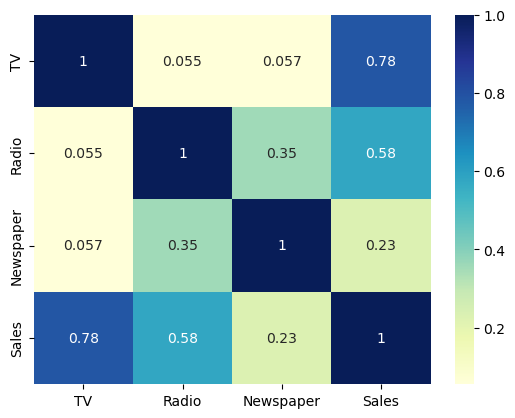

In [8]:
# Matriz de correlaciones
# Hacemos uso del heatmap de la librer√≠a de Seaborn
sns.heatmap(df_advertising.corr(), cmap="YlGnBu", annot = True)
plt.show()

De esta matriz de correlaci√≥n podemos observar que el factor de correlaci√≥n de Pearson entre la variable `TV` y `Sales` es de 0.78, que es la m√°s alta correlaci√≥n que se muestra. Adem√°s, la variable `Radio` tambi√©n tiene un factor de correlaci√≥n de 0.58 considerable con respecto a `Sales`. Sin embargo, tambi√©n vemos un problema de multicolinealidad, pues hay una correlaci√≥n de 0.35 que no podemos ignorar entre dos variables predictoras `Newspaper` y `Radio`. Esto significa, que de alguna manera una de estas variables podr√≠a explicar a la otra hasta cierto punto. Todav√≠a no cuantificamos esta multicolinealidad, pero de haberla, normalmente solo se tomar√≠a en el modelo una de las variables predictoras, puesto que las dos nos estar√≠an dando informaci√≥n similar. 

## Regresi√≥n lineal simple con publicidad en TV

La **regresi√≥n lineal simple** es un modelo que busca describir la relaci√≥n entre una variable predictora $x$ y una variable respuesta continua $y$, mediante una ecuaci√≥n lineal de la forma:

\begin{equation}
\hat{y} = \beta_0 + \beta_1 x
\end{equation}

En este caso, utilizaremos el gasto en **publicidad en TV** como variable predictora ($x$) y las **ventas** como variable respuesta ($y $). Como primer paso, vamos a **calcular manualmente** los par√°metros del modelo, utilizando las f√≥rmulas estad√≠sticas cl√°sicas, antes de recurrir a herramientas automatizadas como `scikit-learn`. Esto nos permitir√° comprender en profundidad c√≥mo se ajusta una recta a los datos y c√≥mo se relacionan los c√°lculos con la geometr√≠a del modelo.

Los par√°metros $\beta_0$ (intercepto) y $\beta_1$ (pendiente) se ajustan de forma que se **minimice la suma de los cuadrados de los errores (residuos)**, es decir, la diferencia entre los valores observados y los predichos por el modelo. Las f√≥rmulas para obtener los valores √≥ptimos son:

\begin{equation}
\beta_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2} = \frac{\rm{Cov}(x,y)}{\sigma_x^2}, \quad \beta_0 = \bar{y} - \beta_1 \bar{x}
\end{equation}

Este modelo nos permitir√° evaluar si existe una relaci√≥n lineal entre el gasto en televisi√≥n y el nivel de ventas, y en qu√© magnitud cambia $y$ ante un cambio unitario en $x$.

In [9]:
# Para mayor facilidad lo dividimos en arrays de variables x=TV, y=ventas
x = df_advertising['TV'].to_numpy() # Datos de TV
y = df_advertising['Sales'].to_numpy() # Datos de Ventas

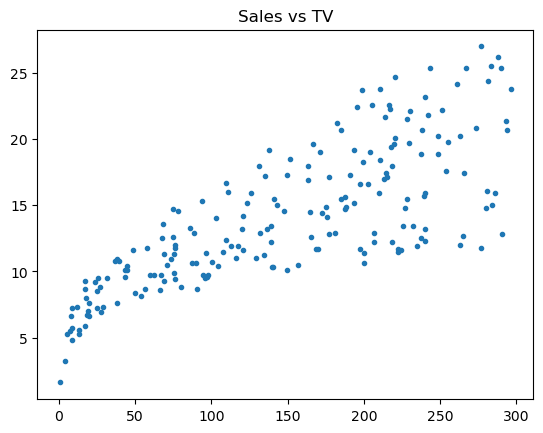

In [10]:
plt.plot(x,y,'.') # Se observa la correlacion
plt.title('Sales vs TV')
plt.show()

In [11]:
# Calculamos medias 

Mu_x = np.mean(x)
Mu_y = np.mean(y)

print('Media x = ', Mu_x, 'Media y =', Mu_y)

Media x =  147.0425 Media y = 14.0225


In [12]:
# Calculamos varianzas y desviaci√≥n estandar

Var_x = np.var(x,ddof=1) ##ddof=1 para especificar que es una muestra
Var_y = np.var(y,ddof=1)

S_x = np.sqrt(Var_x)
S_y = np.sqrt(Var_y)

print('Varianza Sx^2 = ', Var_x, 'Sy^2 =', Var_y)
print ('Desviacion estandar Sx =', S_x, ' Sy =', S_y)

Varianza Sx^2 =  7370.94989321608 Sy^2 = 27.22185301507538
Desviacion estandar Sx = 85.85423631490808  Sy = 5.217456565710478


In [13]:
# Calculamos la covarianza (con numpy)

S_xy = np.cov(x,y)[0][1] ## Corresponde al factor [0][1] de salida, y 
# por default calcula la covarianza de muestra as√≠ que no hay que especificar grados de libertad
print('Covarianza Sxy =', S_xy)

Covarianza Sxy = 350.39019472361804


In [14]:
# Calculamos el coeficiente de Correlaci√≥n de Pearson

r = (S_xy)/(S_x*S_y)
print('Coeficiente de correlacion r =',round(r,3))

Coeficiente de correlacion r = 0.782


Beta0:  7.033
Beta1:  0.048


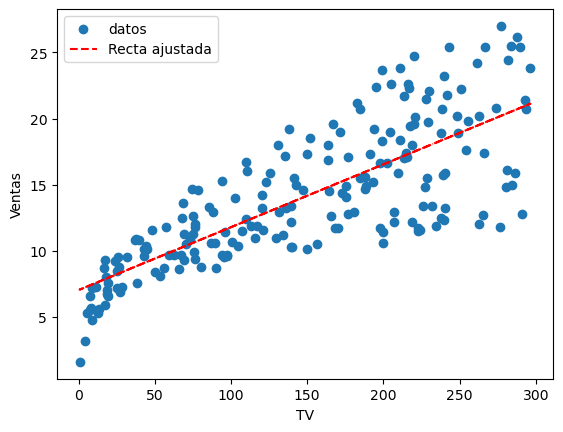

In [15]:
# Hacer la regresi√≥n lineal manualmente

def line(x,beta_0,beta_1): # Definici√≥n de la ecuaci√≥n de una recta
    return beta_0 + beta_1*x

beta_1 = S_xy/(S_x**2.)
beta_0 = Mu_y - (beta_1*Mu_x)

print('Beta0: ', round(beta_0,3))
print('Beta1: ', round(beta_1,3))

# Graficamos esta recta

plt.scatter(x, y, label='datos')
plt.plot(x, line(x, beta_0, beta_1), '--r', label='Recta ajustada')
plt.xlabel('TV')
plt.ylabel('Ventas')
plt.legend()
plt.show()

De esta forma, de acuerdo a los par√°metros de la recta ajustada, podemos escribir nuestro modelo de la siguiente forma:

\begin{equation}
\rm{Ventas} = 7.03 + 0.047 * \rm{TV}
\end{equation}

In [16]:
# Hacemos una lista con los valores predecidos por nuestro modelo para cada x_i de nuestro set de datos
y_pred = []

for value in x:
    y_pred.append(line(value, beta_0, beta_1))
y_pred

[np.float64(17.970774512765537),
 np.float64(9.147974048397074),
 np.float64(7.850223764575636),
 np.float64(14.234394574730185),
 np.float64(15.627218139417664),
 np.float64(7.446162320894969),
 np.float64(9.765950374026332),
 np.float64(12.746497729176669),
 np.float64(7.441408656851667),
 np.float64(16.53041430764504),
 np.float64(10.1747654817503),
 np.float64(17.238710250097032),
 np.float64(8.163965591433566),
 np.float64(11.66741599134712),
 np.float64(16.734821861507022),
 np.float64(16.321253089739752),
 np.float64(10.255577770486434),
 np.float64(20.40940416697945),
 np.float64(10.322129067092662),
 np.float64(14.034740684911505),
 np.float64(17.414595819699205),
 np.float64(18.317791987926583),
 np.float64(7.660077202843558),
 np.float64(17.8852085599861),
 np.float64(9.994126248104827),
 np.float64(19.529976318968583),
 np.float64(13.825579467006218),
 np.float64(18.446140917095732),
 np.float64(18.859709688863006),
 np.float64(10.38868036369889),
 np.float64(20.95607553195

In [17]:
# Hacemos un dataset de x, y ,y lo predicho por el modelo y_model
df_TVS = pd.DataFrame(
    {
        "x":x,
        "y_actual":y,
        "y_model":y_pred
    }
)
df_TVS.head()

x  y_actual    y_model
0  230.1      22.1  17.970775
1   44.5      10.4   9.147974
2   17.2       9.3   7.850224
3  151.5      18.5  14.234395
4  180.8      12.9  15.627218

In [20]:
# Calculamos las sumas al cuadrado
SSR = sum((df_TVS["y_model"] - Mu_y)**2.) ## Regresion y promedio
SSD = sum((df_TVS["y_model"]-df_TVS["y_actual"])**2.) # Regresion y Observacion
SST = sum((df_TVS["y_actual"] - Mu_y)**2.) # Observacion y promedio
print(round(SSR,3),round(SSD,3),round(SST,3))

3314.618 2102.531 5417.149


In [21]:
# Calculo de R2
R2 = SSR / SST
print('R2: ', R2)

R2:  0.6118750508500711


In [22]:
## Error residual
p = 1 # 1 variable predictora
RSE = np.sqrt(SSD/(len(df_advertising) - 1 - p))
print('RSE: ', RSE)

RSE:  3.2586563686504624


In [23]:
## Error residual porcentual
print('RSE porcentual: ', round(RSE / df_TVS['y_actual'].mean(),2), '%')

RSE porcentual:  0.23 %


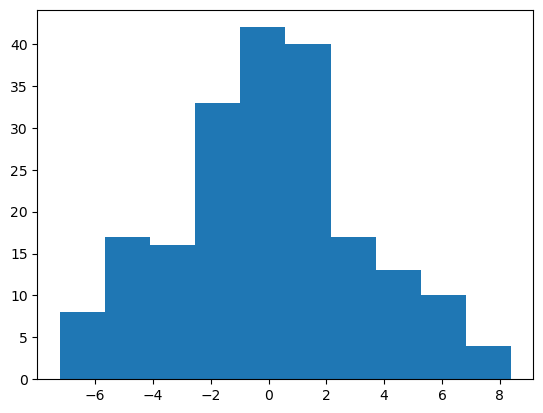

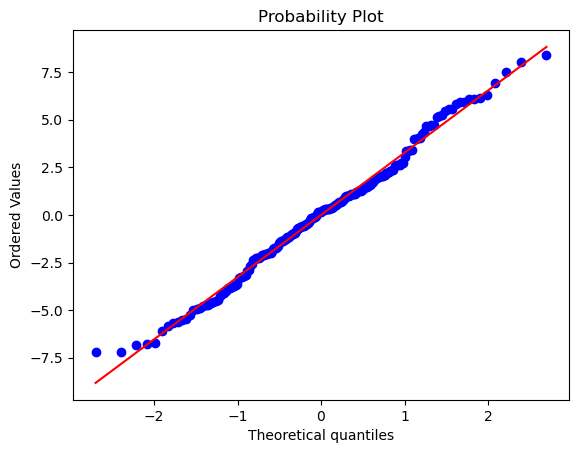

Prueba de Shapiro-Wilk
estad√≠stico W=0.991, p-valor=0.213
Probablemente es gaussiano




In [24]:
# Creamos un histograma de los residuos
plt.hist(df_TVS["y_model"] - df_TVS["y_actual"])
plt.show()

# Vemos que tiene que ser normal
# Podemos aplicar pruebas de normalidad

## Q-Q plot
st.probplot(df_TVS["y_model"] - df_TVS["y_actual"],
            dist='norm',
            plot=plt)
plt.show()

# prueba de normalidad de Shapiro-Wilk
significance = 0.05
standardized_var = st.zscore(df_TVS["y_model"] - df_TVS["y_actual"])
stat, p = st.shapiro(standardized_var)
print('Prueba de Shapiro-Wilk')
print('estad√≠stico W=%.3f, p-valor=%.3f' % (stat,p))
if p > significance:
    print('Probablemente es gaussiano')
else:
    print('Probablemente no es gaussiano')
print('\n')

Los residulos parece que s√≠ siguen una distribuci√≥n normal, lo cu√°l nos dice que es una buena regresi√≥n lineal. Observamos un error residual porcentual del 23%, que nos da una medida de cu√°nto se desv√≠an en promedio los datos observados respecto a las predicciones, tomando en cuenta la escala del problema. En este caso, es un valor moderado.

## Ajuste del modelo con librer√≠as de Python

Despu√©s de realizar los c√°lculos de regresi√≥n lineal **manualmente**, ahora utilizaremos herramientas de Python para **ajustar el modelo de forma automatizada**. En particular, usaremos dos librer√≠as ampliamente utilizadas en ciencia de datos y estad√≠stica: `scikit-learn` y `statsmodels`.

- **`scikit-learn`** est√° orientada principalmente al **aprendizaje autom√°tico**. Su enfoque es pr√°ctico y centrado en la predicci√≥n: ofrece una interfaz uniforme para entrenar modelos, hacer predicciones y evaluar el rendimiento, pero no proporciona detalles estad√≠sticos del ajuste (como errores est√°ndar o pruebas de hip√≥tesis).
  
- **`statsmodels`**, en cambio, est√° m√°s enfocada al **an√°lisis estad√≠stico cl√°sico**. Permite ajustar modelos lineales y obtener un resumen completo con coeficientes, errores est√°ndar, intervalos de confianza, valores p, $R^2$, entre otros. Es ideal cuando se busca interpretar el modelo y evaluar la significancia estad√≠stica de los predictores.

Utilizar ambos enfoques nos permitir√° entender el mismo modelo desde dos perspectivas complementarias: la predictiva y la inferencial.

## Regresi√≥n lineal simpole con `statsmodels`

In [25]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
df_advertising.head()

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

In [26]:
# Con la paqueter√≠a statsmodels podemos crear un modelo lineal

# Hacemos la instancia del modelo y el entrenamiento (fit)
lm = smf.ols(formula = "Sales~TV", data = df_advertising).fit() #formula de la regresion Ventas en funcion de TV
#fit ajusta el modelo de acuerdo a estas condiciones (ols, ordinary least squares)

In [27]:
type(lm)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [28]:
lm.params # Nos regresa los parametros (beta0, beta1)

Intercept    7.032594
TV           0.047537
dtype: float64

Observamos que los par√°metros de ajuste $\beta_0$ y $\beta_1$ son id√©nticos a los que ten√≠amos al hacerlo manualmente. Adicionalmente, esta paqueter√≠a tambi√©n puede calcular diferentes pruebas de hip√≥tesis √∫tiles de los par√°metros para evaluaci√≥n.

In [29]:
lm.pvalues
# pvales para hacer el test de hipotesis y verificar que nuestros par√°metros no son cero
# La hipotesis alternativa (que si son diferentes de cero) se toma si los p values son menores a 5%

Intercept    1.406300e-35
TV           1.467390e-42
dtype: float64

In [30]:
lm.rsquared # Calculo de R2
## Tenemos 0.61

np.float64(0.611875050850071)

El valor de $R^2$ es id√©ntico al que calculamos a mano.

In [31]:
lm.rsquared_adj
# Modificacion de R2 al penalizar por la inclusi√≥n de varias variables predictoras.

np.float64(0.6099148238341623)

In [32]:
lm.summary() #resumen del modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.47e-42
Time:                        23:35:39   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Una de las principales ventajas de utilizar `statsmodels` para ajustar modelos de regresi√≥n es su capacidad de generar un **resumen estad√≠stico completo** mediante el m√©todo `.summary()`. Este resumen no solo muestra los coeficientes estimados del modelo, sino tambi√©n informaci√≥n esencial para su interpretaci√≥n: **errores est√°ndar**, **valores t**, **valores p** para pruebas de hip√≥tesis, **intervalos de confianza**, y medidas de calidad del ajuste como $R^2$, $R^2$ ajustado, AIC y BIC. Adem√°s, incluye diagn√≥sticos de normalidad de residuos y estad√≠sticos globales del modelo como la prueba F. Esta informaci√≥n permite evaluar no solo si el modelo predice bien, sino tambi√©n si **los predictores son estad√≠sticamente significativos**, lo cual es fundamental en contextos donde se requiere una justificaci√≥n formal del modelo y sus variables.

In [33]:
sales_pred = lm.predict(df_advertising["TV"]) # generar una columna con una prediccion del modelo en hase a la columna x
sales_pred

0      17.970775
1       9.147974
2       7.850224
3      14.234395
4      15.627218
         ...    
195     8.848493
196    11.510545
197    15.446579
198    20.513985
199    18.065848
Length: 200, dtype: float64

In [34]:
type(sales_pred)

pandas.core.series.Series

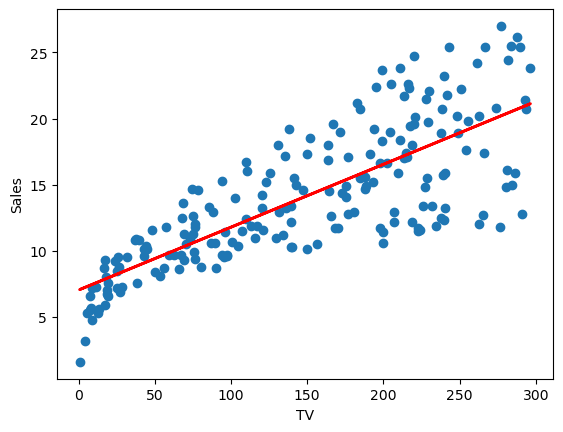

In [35]:
# Graficamos para comparar
plt.scatter(df_advertising['TV'], df_advertising['Sales'])
plt.plot(df_advertising["TV"], sales_pred, c="red", linewidth = 2)
plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

In [36]:
## Error estadar residual
## Agregamos una columa con los valores predecidos por el modelo
df_advertising["sales_pred"] = 7.032594 + 0.047537*df_advertising["TV"]

In [37]:
#a√±adir columna de residual (la diferencia entre lo observado y lo predicho al cuadrado)
df_advertising["RSE"] = (df_advertising["Sales"] - df_advertising["sales_pred"])**2.

In [38]:
df_advertising.head()

TV  Radio  Newspaper  Sales  sales_pred        RSE
0  230.1   37.8       69.2   22.1   17.970858  17.049816
1   44.5   39.3       45.1   10.4    9.147990   1.567528
2   17.2   45.9       69.3    9.3    7.850230   2.101832
3  151.5   41.3       58.5   18.5   14.234450  18.194921
4  180.8   10.8       58.4   12.9   15.627284   7.438076

In [39]:
SSD = sum(df_advertising["RSE"]) ### sumamos todas las diferencias al cuadrado para calcular SSD
SSD

2102.5305838896525

In [40]:
## Calculamos el error residual
p = 1 # variables predictoras
RSE = np.sqrt(SSD/(len(df_advertising) - 1 - p))
print('RSE: ', RSE)

RSE:  3.258656369238098


In [41]:
 # cuanto represetnta con respecto al numero total de ventas
sales_m = np.mean(df_advertising["Sales"])
sales_m #el promedio de ventas

np.float64(14.0225)

In [42]:
# RSE porcentual
error = RSE/sales_m
error # erro 23% que no queda explicado por el modelo

np.float64(0.23238768901680143)

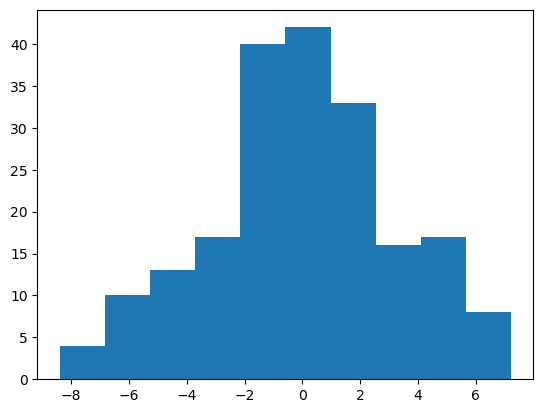

In [43]:
plt.hist(df_advertising["Sales"] - df_advertising["sales_pred"]) # es mas o menos una distribuci√≥n normal
plt.show()

Vemos que la distribucion del error si tiene una forma normal, como tendr√≠a que comportarse. Los p-values son bajitos, no son cero, lo que nos dice que el modelo es s√≥lido, aunque es incapaz de explicar la discrepancia que hay del 23%. Esto se puede reducir incluyendo m√°s variables.

El coeficiente $R^2$ ajustado se calcula de la siguiente forma:

\begin{equation}
R^2 \ \rm{adj} = 1 - \frac{(1-R^2) (n-1)}{n-k-1}
\end{equation}

siendo $k$ el n√∫mero de variables predictoras.


## Regresi√≥n lineal simple con `scikit-learn`

Seguimos los pasos t√≠picos que ya vimos anteriormente, para trabajar con la librer√≠a `scikit-learn`.

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

R2:  0.611875050850071
MSE:  10.512652915656757
RMSE:  3.2423221486546887

Par√°metros del ajuste
beta_0:  7.032593549127695
beta_1:  [0.04753664]


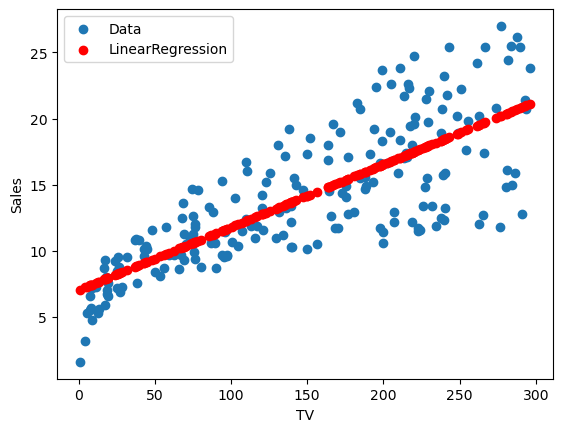

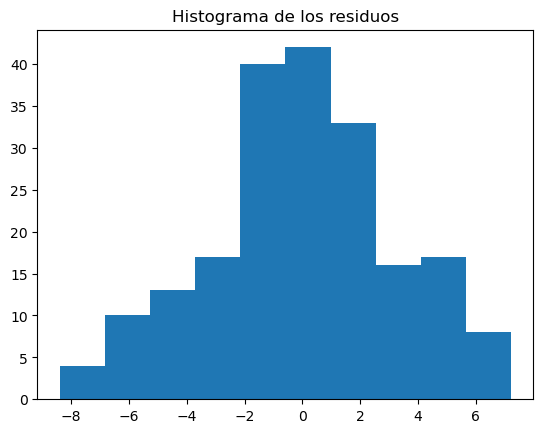

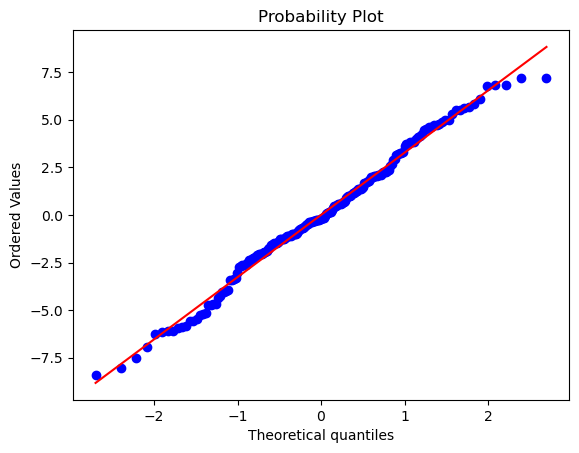

Prueba de Shapiro-Wilk
estad√≠stico W=0.991, p-valor=0.213
Probablemente es gaussiano




In [44]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

##
X = df_advertising['TV'].to_frame() ## matriz de caracteristicas, si solo tenemos una caracteristica, se tiene que transformar a DataFrame
y = df_advertising['Sales'] ## variable objetivo

## Modelado con scikit-learn

# 1. instancia el modelo
model_lm = LinearRegression(fit_intercept=True)

# 2. entrenar el modelo
model_lm.fit(X,y)

# 3. hacer predicciones
y_pred = model_lm.predict(X)

# 4. evaluacion con metricas
r2 = r2_score(y, y_pred) # para r2 si importa el orden de los argumentos (y_real, y_predicha)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print('R2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('')
print('Par√°metros del ajuste')
print('beta_0: ', model_lm.intercept_)
print('beta_1: ', model_lm.coef_)

# Plot
plt.scatter(X, y, label='Data')
plt.scatter(X, y_pred, c="red", label='LinearRegression')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.legend()
plt.show()

# residuos
res = y - y_pred

# plot residuos
plt.hist(res)
plt.title("Histograma de los residuos")
plt.show()

## Q-Q plot
st.probplot(res,
            dist='norm',
            plot=plt)
plt.show()

# prueba de normalidad de Shapiro-Wilk
significance = 0.05
standardized_var = st.zscore(res)
stat, p = st.shapiro(standardized_var)
print('Prueba de Shapiro-Wilk')
print('estad√≠stico W=%.3f, p-valor=%.3f' % (stat,p))
if p > significance:
    print('Probablemente es gaussiano')
else:
    print('Probablemente no es gaussiano')
print('\n')

Como vemos, los par√°metros que se obtienen con `scikit-learn` son exactamente los mismos.

Tanto `scikit-learn` como `statsmodels` nos permiten ajustar modelos de regresi√≥n lineal simple de forma eficiente, pero con enfoques distintos. `scikit-learn` est√° dise√±ado principalmente para tareas de **predicci√≥n autom√°tica**, por lo que su interfaz es simple y directa: entrenar el modelo, hacer predicciones y evaluar el rendimiento con m√©tricas como $R^2$ o el error cuadr√°tico medio. Por otro lado, `statsmodels` est√° m√°s enfocado en el **an√°lisis estad√≠stico detallado**: proporciona un resumen completo del modelo con coeficientes, errores est√°ndar, valores p, intervalos de confianza y m√©tricas de ajuste como AIC y BIC.

Ambas herramientas producen los mismos coeficientes num√©ricos cuando el modelo es el mismo, pero su salida y enfoque responden a necesidades diferentes: `scikit-learn` para predicci√≥n eficiente en pipelines de machine learning, y `statsmodels` para an√°lisis inferencial y evaluaci√≥n de la significancia estad√≠stica de las variables. Utilizar ambos complementa la comprensi√≥n te√≥rica y pr√°ctica del modelo de regresi√≥n.


# Regresi√≥n lineal m√∫ltiple

La regresi√≥n lineal por m√≠nimos cuadrados ordinarios (OLS, por sus siglas en ingl√©s: *Ordinary Least Squares*) es uno de los modelos estad√≠sticos m√°s utilizados para **explicar la relaci√≥n entre una variable dependiente y una o m√°s variables independientes**.

En su forma m√°s simple, OLS asume una relaci√≥n lineal entre los predictores y la respuesta, y busca encontrar la l√≠nea (o hiperplano) que **minimiza la suma de los errores al cuadrado** entre las predicciones del modelo y los valores observados.

---

### Forma general del modelo

\begin{equation}
\hat{y}_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip} + \varepsilon_i
\end{equation}

donde,

- $y_i$: valor observado de la variable dependiente para la observaci√≥n $i$. 
- $x_{ij}$: valor del predictor $j$ en la observaci√≥n $i$.  
- $\beta_j$: coeficientes del modelo (par√°metros estimados)  
- $\varepsilon_i$: t√©rmino de error (ruido no explicado por el modelo)  

El objetivo del modelo es encontrar los valores de $\beta_0, \beta_1, \dots, \beta_p$ que **mejor ajustan** los datos, minimizando la suma de errores al cuadrado o residuos:

\begin{equation}
\sum_{i=1}^n (y_i - \hat{y}_i)^2
\end{equation}

donde $\hat{y}_i$ son los valores predichos por dicho modelo

### Dataset de advertising
Siguiendo est√° l√≠nea, en este caso vamos a considerar el gasto de radio y periodico. Vamos a incrementar la eficacia del modelo introduciendo m√°s variables. Para esto tendr√≠amos 7 modelos distintos:
* Sales - TV
* Sales - Radio
* Sales - Periodico
* Sales - TV + Periodico
* Sales - TV + Radio
* Sales - Periodico + Radio
* Sales - TV + Periodico + Radio
Siete modelos lineales, uno por cada combinaci√≥n de variables.

Las reglas recomendadas que empecemos con un modelo que empieze con todas las variables y veamos los p valores peque√±o. Todo lo que este por arriba no nos sirven. No es un indicador bueno pero es un punto de partida. **Queremos que el R2 ajustado aumente.**.

De la misma forma que lo hicimos para **regresi√≥n lineal simple**, vamos a empezar por el caso manual.

El modelo lineal tambi√©n se puede expresar de forma matricial por $Y = X \beta + \epsilon$ (cada variables es una matriz), expresada de la siguiente forma:

\begin{equation}
\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix} =
\begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1q} \\
1 & x_{21} & x_{22} & \cdots & x_{2q} \\
\vdots & \vdots & \vdots & & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{nq} \\
\end{pmatrix}
\begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_q
\end{pmatrix}
+
\begin{pmatrix}
\varepsilon_1 \\
\varepsilon_2 \\
\vdots \\
\varepsilon_n
\end{pmatrix}
\end{equation}

El n√∫mero de filas $n$ corresponde al n√∫mero de observaciones de los datos. El n√∫mero de variables de entrada est√° dado por $q$, y este valor nos resulta en el n√∫mero de variables a ajustar para el modelo lineal $\beta_0, \beta_1 \ldots \beta_q$. Por lo tanto, las dimensiones de las matrices son las siguientes, $Y (n \times 1)$, $X (n \times (q+1))$, $\beta ((q+1) \times 1)$, $\epsilon (n \times 1)$. Recordar que una operaci√≥n entre matrices tiene que tomar en cuenta las dimensiones entre ellas, y normalmente no es conmutativa $(XY \ne YX)$.

**Soluci√≥n al problema de regresi√≥n lineal m√∫ltiple por m√≠nimos cuadrados ordinarios (OLS)**
En un problema de regresi√≥n lineal multivariable, el vector de par√°metros √≥ptimos $\beta$ se encuentra utilizando normalmente el m√©todo de m√≠nimos cuadrados ordinarios (OLS), utilizando la siguiente ecuaci√≥n,

\begin{equation}
\beta = (X^TX)^{-1}X^TY
\end{equation}

Podemos ir construyendo estas matrices utilizando la librer√≠a de `numpy`en python. Vamos a empezar, por un caso simple, el modelo Sales = TV + Newspaper

In [45]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

In [46]:
# Creamos la matriz X
# Cremos una lista de 1's que tenga la misma longitud que los datos
x = []
for i in range(0,df_advertising.shape[0]):
    x.append(1.0)

# Creamos lista con la primer variable
x1 = df_advertising['TV'].values.tolist()
# Creamos una lista con la segunda variable
x2 = df_advertising['Newspaper'].values.tolist()

# Creamos la matriz X
X = []
for i in range(0,df_advertising.shape[0]):
    X.append([x[i],x1[i],x2[i]])
    print([x[i],x1[i],x2[i]])

[1.0, 230.1, 69.2]
[1.0, 44.5, 45.1]
[1.0, 17.2, 69.3]
[1.0, 151.5, 58.5]
[1.0, 180.8, 58.4]
[1.0, 8.7, 75.0]
[1.0, 57.5, 23.5]
[1.0, 120.2, 11.6]
[1.0, 8.6, 1.0]
[1.0, 199.8, 21.2]
[1.0, 66.1, 24.2]
[1.0, 214.7, 4.0]
[1.0, 23.8, 65.9]
[1.0, 97.5, 7.2]
[1.0, 204.1, 46.0]
[1.0, 195.4, 52.9]
[1.0, 67.8, 114.0]
[1.0, 281.4, 55.8]
[1.0, 69.2, 18.3]
[1.0, 147.3, 19.1]
[1.0, 218.4, 53.4]
[1.0, 237.4, 23.5]
[1.0, 13.2, 49.6]
[1.0, 228.3, 26.2]
[1.0, 62.3, 18.3]
[1.0, 262.9, 19.5]
[1.0, 142.9, 12.6]
[1.0, 240.1, 22.9]
[1.0, 248.8, 22.9]
[1.0, 70.6, 40.8]
[1.0, 292.9, 43.2]
[1.0, 112.9, 38.6]
[1.0, 97.2, 30.0]
[1.0, 265.6, 0.3]
[1.0, 95.7, 7.4]
[1.0, 290.7, 8.5]
[1.0, 266.9, 5.0]
[1.0, 74.7, 45.7]
[1.0, 43.1, 35.1]
[1.0, 228.0, 32.0]
[1.0, 202.5, 31.6]
[1.0, 177.0, 38.7]
[1.0, 293.6, 1.8]
[1.0, 206.9, 26.4]
[1.0, 25.1, 43.3]
[1.0, 175.1, 31.5]
[1.0, 89.7, 35.7]
[1.0, 239.9, 18.5]
[1.0, 227.2, 49.9]
[1.0, 66.9, 36.8]
[1.0, 199.8, 34.6]
[1.0, 100.4, 3.6]
[1.0, 216.4, 39.6]
[1.0, 182.6, 58.7]
[1.0

In [47]:
# Creamos Matriz Y
y = df_advertising['Sales'].values.tolist()
Y = []
for i in range(0,df_advertising.shape[0]):
        Y.append([y[i]])
        print([y[i]])

[22.1]
[10.4]
[9.3]
[18.5]
[12.9]
[7.2]
[11.8]
[13.2]
[4.8]
[10.6]
[8.6]
[17.4]
[9.2]
[9.7]
[19.0]
[22.4]
[12.5]
[24.4]
[11.3]
[14.6]
[18.0]
[12.5]
[5.6]
[15.5]
[9.7]
[12.0]
[15.0]
[15.9]
[18.9]
[10.5]
[21.4]
[11.9]
[9.6]
[17.4]
[9.5]
[12.8]
[25.4]
[14.7]
[10.1]
[21.5]
[16.6]
[17.1]
[20.7]
[12.9]
[8.5]
[14.9]
[10.6]
[23.2]
[14.8]
[9.7]
[11.4]
[10.7]
[22.6]
[21.2]
[20.2]
[23.7]
[5.5]
[13.2]
[23.8]
[18.4]
[8.1]
[24.2]
[15.7]
[14.0]
[18.0]
[9.3]
[9.5]
[13.4]
[18.9]
[22.3]
[18.3]
[12.4]
[8.8]
[11.0]
[17.0]
[8.7]
[6.9]
[14.2]
[5.3]
[11.0]
[11.8]
[12.3]
[11.3]
[13.6]
[21.7]
[15.2]
[12.0]
[16.0]
[12.9]
[16.7]
[11.2]
[7.3]
[19.4]
[22.2]
[11.5]
[16.9]
[11.7]
[15.5]
[25.4]
[17.2]
[11.7]
[23.8]
[14.8]
[14.7]
[20.7]
[19.2]
[7.2]
[8.7]
[5.3]
[19.8]
[13.4]
[21.8]
[14.1]
[15.9]
[14.6]
[12.6]
[12.2]
[9.4]
[15.9]
[6.6]
[15.5]
[7.0]
[11.6]
[15.2]
[19.7]
[10.6]
[6.6]
[8.8]
[24.7]
[9.7]
[1.6]
[12.7]
[5.7]
[19.6]
[10.8]
[11.6]
[9.5]
[20.8]
[9.6]
[20.7]
[10.9]
[19.2]
[20.1]
[10.4]
[11.4]
[10.3]
[13.2]
[25.4

In [48]:
# Calculamos la matriz X transpuesta con numpy
X_T = np.transpose(X)
print(X_T)

[[  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.   

In [49]:
# Calculamos el producto de X^T X
M = X_T.dot(X)
print(M)

[[2.00000000e+02 2.94085000e+04 6.11080000e+03]
 [2.94085000e+04 5.79111839e+06 9.19625280e+05]
 [6.11080000e+03 9.19625280e+05 2.81096740e+05]]


In [50]:
# calculamos matriz inversa (X^T X)^-1
M_i = np.linalg.inv(M)
print(M_i)

[[ 2.83379032e-02 -9.59019392e-05 -3.02292412e-04]
 [-9.59019392e-05  6.83942117e-07 -1.52733508e-07]
 [-3.02292412e-04 -1.52733508e-07  1.06287468e-05]]


In [51]:
# calculamos toda la ecuaci√≥n completa de los parametros optimos (X^T X)^-1 X^T Y

# primero X^T * Y
B = X_T.dot(Y)

# luego (X^T X)^-1 por lo anterior
Beta = M_i.dot(B)

print(Beta)

[[5.77494797]
 [0.04690121]
 [0.04421942]]


Este es el vector de par√°metros √≥ptimos, cuyas entradas son $\beta_0, \beta_1, \beta_2, \ldots$. Veamos si nos salen los mismos par√°metros √≥ptimos utilizando scikit-learn. Podemos reutilizar el c√≥digo que hicimos para el caso de regresi√≥n lineal simple, pues s√≥lo tenemos que agregar una variable predictora adicional.

### Regresi√≥n lineal m√∫ltiple con scikit-learn

In [52]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

##
X = df_advertising[['TV','Newspaper']] ## matriz de caracteristicas, aqu√≠ incluimos variables adicionales, ya no es necesario transformar a dataframe
y = df_advertising['Sales'] ## variable objetivo

## Modelado con scikit-learn

# 1. instancia el modelo
model_lm = LinearRegression(fit_intercept=True)

# 2. entrenar el modelo
model_lm.fit(X,y)

# 3. hacer predicciones
y_pred = model_lm.predict(X)

# 4. evaluacion con metricas
r2 = r2_score(y, y_pred) # para r2 si importa el orden de los argumentos (y_real, y_predicha)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print('Resultados para Sales ~ TV + Newspaper')
print('R2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('')
print('Par√°metros del ajuste')
print('beta_0: ', model_lm.intercept_)
print('beta_1: ', model_lm.coef_[0])
print('beta_2: ', model_lm.coef_[1])

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

Resultados para Sales ~ TV + Newspaper
R2:  0.6458354938293271
MSE:  9.59280905948414
RMSE:  3.097226026541192

Par√°metros del ajuste
beta_0:  5.7749479679116344
beta_1:  0.04690121389190707
beta_2:  0.04421942424519282


Como podemos observar, son exactamente los mismos par√°metros $\beta_i$ de ajuste.

## üß† Importancia de entender el modelo m√°s all√° de la caja negra

En el aprendizaje autom√°tico, es com√∫n utilizar herramientas que nos permiten entrenar modelos y obtener predicciones r√°pidamente. Sin embargo, tratar estos modelos como **"cajas negras"** ‚Äîes decir, aplicar algoritmos sin comprender su l√≥gica interna‚Äî puede llevar a interpretaciones err√≥neas, decisiones mal fundamentadas o incluso modelos inadecuados para el problema. Comprender c√≥mo funciona un modelo de regresi√≥n lineal, c√≥mo se calculan sus par√°metros, qu√© suposiciones implica y c√≥mo interpretar sus salidas, nos permite **diagnosticar su comportamiento**, **identificar errores** y **comunicar sus resultados de manera responsable**. Esta comprensi√≥n es fundamental, sobre todo en contextos donde la interpretabilidad y la justificaci√≥n de las decisiones basadas en datos son tan importantes como la predicci√≥n misma.

Sabiendo esto, ahora s√≠ podemos pasar a aplicar de manera iterada la metodolog√≠a de la paqueter√≠a de scikit-learn, para todas las combinaciones de variables posible para este problema. Para esto, vamos a modificar un poco el c√≥digo que ten√≠amos anteriormente.

**NOTA** A diferencia de `statsmodels`, `scikit-learn` no incluye directamente el c√°lculo del R2 ajustado, as√≠ que hay que calcularlo manualmente.

In [53]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath, filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

# Variables predictoras y objetivo
predictors = ['TV', 'Radio', 'Newspaper']
y = df_advertising['Sales']

# Loop sobre combinaciones de 1 a 3 predictores
for k in range(1, len(predictors)+1):
    for combo in combinations(predictors, k):
        X = df_advertising[list(combo)]

        # Modelado
        model_lm = LinearRegression(fit_intercept=True)
        model_lm.fit(X, y)
        y_pred = model_lm.predict(X)

        # M√©tricas
        r2 = r2_score(y, y_pred)
        n = X.shape[0]  # n√∫mero de observaciones
        p = X.shape[1]  # n√∫mero de predictores
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Resultados
        print(f"\nModelo con variables: {combo}")
        print(f"R2: {r2:.4f} | R2 ajustado: {r2_adj:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")
        print("Coeficientes:")
        print(f"  Beta_0 (intercepto): {model_lm.intercept_:.4f}")
        for i, var in enumerate(combo):
            print(f"  Beta_{i+1} ({var}): {model_lm.coef_[i]:.4f}")

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9


Modelo con variables: ('TV',)
R2: 0.6119 | R2 ajustado: 0.6099 | MSE: 10.5127 | RMSE: 3.2423
Coeficientes:
  Beta_0 (intercepto): 7.0326
  Beta_1 (TV): 0.0475

Modelo con variables: ('Radio',)
R2: 0.3320 | R2 ajustado: 0.3287 | MSE: 18.0924 | RMSE: 4.2535
Coeficientes:
  Beta_0 (intercepto): 9.3116
  Beta_1 (Radio): 0.2025

Modelo con variables: ('Newspaper',)
R2: 0.0521 | R2 ajustado: 0.0473 | MSE: 25.6740 | RMSE: 5.0670
Coeficientes:
  Beta_0 (intercepto): 12.3514
  Beta_1 (Newspaper): 0.0547

Modelo con variables: ('TV', 'Radio')
R2: 0.8972 | R2 ajustado: 0.8962 | MSE: 2.7846 | RMSE: 1.6687
Coeficientes:
  Beta_0 (intercepto): 2.9211
  Beta_1 (TV): 0.0458
  Beta_2 (Radio): 0.1880

Modelo con variables: ('TV', 'Newspaper')
R2: 0.6458 | R2 ajustado: 0.6422 | MSE: 9.5928 | RMSE: 3.0972
Coeficientes:
  Beta_0 (intercepto): 5.7749
  Beta_1 (TV): 0.0469
  Beta_2 (Newspaper): 0.0442

Modelo con variables: ('Radio', 'Newspaper')
R2: 0.3327 | R2 ajustado: 0.3259 | MSE: 18.0742 | RMSE: 4.251

Entonces, de todas las combinaciones de todos los modelos, la combinaci√≥n que resulta con una mejor m√©trica de $R^2=$0.8962 ajustado es aquella que incluye `TV` y `Radio`. Esta m√©trica, de hecho, no es muy diferente a aquella de $R^2=$0.8956, que incluye las tres variables.

## ‚ö†Ô∏è Mito: "M√°s variables siempre mejoran el modelo"

Es com√∫n pensar que incluir m√°s variables predictoras en un modelo de regresi√≥n siempre resultar√° en un mejor desempe√±o. Sin embargo, esto es un **mito estad√≠stico**. Aunque el coeficiente $R^2$ tiende a aumentar al a√±adir m√°s variables (incluso irrelevantes), esto no significa que el modelo sea realmente mejor. Incluir variables innecesarias puede llevar a **sobreajuste**, dificultar la interpretaci√≥n del modelo, aumentar la **colinealidad** y disminuir la **capacidad de generalizaci√≥n** a nuevos datos. Por eso se utiliza el **$R^2$ ajustado**, que penaliza el n√∫mero de variables y permite identificar cu√°ndo una nueva variable realmente aporta valor. Un buen modelo no es el que m√°s variables incluye, sino el que logra **equilibrar simplicidad, interpretabilidad y rendimiento predictivo**. Como comparaci√≥n, vamos a ver como sale el summary del modelo de tres variables predictivas con `statsmodels`.


In [54]:
lm = smf.ols(formula="Sales~TV+Newspaper+Radio", data=df_advertising).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.58e-96
Time:                        23:36:06   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Si nos fijamos muy bien en el summary del modelo, podemos ver que los par√°metros de ajuste, as√≠ como las m√©tricas son b√°sicamente las mismas. Sin embargo, una caracter√≠stica importante aqu√≠ son las pruebas de hip√≥tesis que se aplica a cada factor $\beta_i$. Por ejemplo, aqu√≠ observamos que el par√°metro $\beta$ asociado d la variable `Newspaper` tiene un p-valor de. 0.86, muy por encima de un nivel de significancia de 0.05, lo que significa que no hay raz√≥n estad√≠stica para decir que este factor es diferente de cero, algo que no queremos de un factor $\beta$. S√≥lo es un recordatorio que una m√©trica por s√≠ sola, no es suficiente para evaluar el rendimiento de un modelo, sino que se tienen que usar diferentes puntos de vista.

## Multicolinealidad
Se hacen correlaciones entre variables predictoras del modelo. Aunque no lo queramos el periodico esta relacionado con la radio, e incrementan la variabilidad del coeficiente estimado para la variable predictora. Una interact√∫a negativamente con la otra. Vemos cual de las dos conviene mas incluir, pero no las dos. Es √∫til ver como afectan el modelo.

## Factor de inflacion de la varianza
Es una prueba para detectar la multicolinealidad a trav√©s de un estad√≠stico. Cuantifica la aparacion de la variabilidad en un coeficiente estimado debida a la alta correlacion entre las variables predictoras. Lo mejor que puede pasar que que VIF = 1, en este caso las variables no tienen nada de correlacion,1-5 correlacion moderada pero pueden formar parte del modelo, >5 necesitan ser eliminadas del modelo.

In [55]:
# Periodico - TV + Radio nos da problema 
# Sacamos R2 , y lugo VIF = 1/(1-R^2)

lm_n = smf.ols(formula="Newspaper~TV+Radio",data=df_advertising).fit()

rsquared_n = lm_n.rsquared
VIF = 1 / (1-rsquared_n)
VIF

np.float64(1.1451873787239288)

In [56]:
# TV - Periodico + Radio nos da problema 

lm_tv = smf.ols(formula="TV~Newspaper+Radio",data=df_advertising).fit()

rsquared_tv = lm_tv.rsquared
VIF = 1 / (1-rsquared_tv)
VIF

#vemos que la tele no esta correlacionada con nadie mas

np.float64(1.00461078493965)

In [57]:
# Radio - TV + Periodico nos da problema 

lm_r = smf.ols(formula="Radio~TV+Newspaper",data=df_advertising).fit()

rsquared_r = lm_r.rsquared
VIF = 1 / (1-rsquared_r)
VIF

np.float64(1.1449519171055353)

La radio y el periodico tienen el casi el mismo VIF, y podemos decir que estan correlacionadas la una con la otra, pero no con la tele. Es de suponer que el indice VIF es m√°s grande para estas dos variables. Decidimos quedarnos con la radio porque nos da una mejor predicci√≥n.

## Resumen del aprendizaje

- Comprendimos la estructura y el prop√≥sito de un modelo de regresi√≥n lineal.
- Calculamos manualmente los coeficientes √≥ptimos, residuos y m√©tricas de evaluaci√≥n.
- Aprendimos a utilizar `scikit-learn` para tareas de predicci√≥n r√°pida y `statsmodels` para an√°lisis estad√≠stico detallado.
- Implementamos regresiones simples y m√∫ltiples, evaluando el impacto de distintas combinaciones de variables.
- Reforzamos la importancia del an√°lisis de residuos, el uso de $R^2$ ajustado, y el cuidado al incluir m√∫ltiples predictores.
- Concluimos que un buen modelo no es necesariamente el m√°s complejo, sino el que logra equilibrio entre **precisi√≥n, parsimonia e interpretabilidad**.


## Conclusi√≥n

A lo largo de este notebook, exploramos de manera progresiva los conceptos fundamentales de la **regresi√≥n lineal**, tanto en su forma simple como m√∫ltiple. Comenzamos generando un modelo con una sola variable predictora para comprender a detalle c√≥mo se calculan manualmente los coeficientes, los residuos, el $R^2$, y el error est√°ndar de los residuos. Posteriormente, utilizamos herramientas como `scikit-learn` y `statsmodels` para ajustar modelos de manera automatizada, comparando sus enfoques predictivo e inferencial. Finalmente, ampliamos el an√°lisis al caso de regresi√≥n lineal m√∫ltiple, evaluando c√≥mo el n√∫mero y tipo de variables influyen en el ajuste del modelo y por qu√© incluir m√°s variables no siempre es mejor. Esta experiencia pr√°ctica sienta las bases para abordar modelos m√°s complejos, siempre con una comprensi√≥n cr√≠tica de su comportamiento, sus supuestos y sus implicaciones.


